In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, \
         0.21, 0.22, 0.23, 0.24, 0.25, 0.25, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
i_beta_31_06 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 100    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.6
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 1))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_31_06[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 66.39719152450562 
    loop_MC 1 - time has passed: 124.39508008956909 
    loop_MC 2 - time has passed: 187.14635968208313 
    loop_MC 3 - time has passed: 258.7933621406555 
    loop_MC 4 - time has passed: 338.8160572052002 
    loop_MC 5 - time has passed: 419.5757987499237 
    loop_MC 6 - time has passed: 463.08979988098145 
    loop_MC 7 - time has passed: 536.2165415287018 
    loop_MC 8 - time has passed: 611.8182616233826 
    loop_MC 9 - time has passed: 693.8239357471466 
    loop_MC 10 - time has passed: 767.4776666164398 
    loop_MC 11 - time has passed: 841.9783244132996 
    loop_MC 12 - time has passed: 911.3633942604065 
    loop_MC 13 - time has passed: 972.5040719509125 
    loop_MC 14 - time has passed: 1037.8555963039398 
    loop_MC 15 - time has passed: 1102.4730637073517 
    loop_MC 16 - time has passed: 1175.567856311798 
    loop_MC 17 - time has passed: 1235.189330816269 
    loop_MC 18 - time has passed: 1308.328055620193

    loop_MC 54 - time has passed: 3666.2231826782227 
    loop_MC 55 - time has passed: 3727.943987607956 
    loop_MC 56 - time has passed: 3785.4369962215424 
    loop_MC 57 - time has passed: 3844.077563524246 
    loop_MC 58 - time has passed: 3925.119820356369 
    loop_MC 59 - time has passed: 4007.199250459671 
    loop_MC 60 - time has passed: 4073.385430574417 
    loop_MC 61 - time has passed: 4135.591289520264 
    loop_MC 62 - time has passed: 4205.440482378006 
    loop_MC 63 - time has passed: 4271.264570951462 
    loop_MC 64 - time has passed: 4335.596619606018 
    loop_MC 65 - time has passed: 4398.352711677551 
    loop_MC 66 - time has passed: 4461.637830257416 
    loop_MC 67 - time has passed: 4538.490631818771 
    loop_MC 68 - time has passed: 4612.376677513123 
    loop_MC 69 - time has passed: 4675.659526586533 
    loop_MC 70 - time has passed: 4743.964927434921 
    loop_MC 71 - time has passed: 4813.689700126648 
    loop_MC 72 - time has passed: 4883.49608

    loop_MC 7 - time has passed: 523.6757338047028 
    loop_MC 8 - time has passed: 591.373292684555 
    loop_MC 9 - time has passed: 659.2704393863678 
    loop_MC 10 - time has passed: 732.7092478275299 
    loop_MC 11 - time has passed: 814.5010323524475 
    loop_MC 12 - time has passed: 876.8805003166199 
    loop_MC 13 - time has passed: 956.6342890262604 
    loop_MC 14 - time has passed: 1032.8235492706299 
    loop_MC 15 - time has passed: 1092.758440732956 
    loop_MC 16 - time has passed: 1174.5924224853516 
    loop_MC 17 - time has passed: 1233.0714902877808 
    loop_MC 18 - time has passed: 1274.0697503089905 
    loop_MC 19 - time has passed: 1341.4108278751373 
    loop_MC 20 - time has passed: 1421.2844066619873 
    loop_MC 21 - time has passed: 1489.768215894699 
    loop_MC 22 - time has passed: 1552.0848960876465 
    loop_MC 23 - time has passed: 1618.7760326862335 
    loop_MC 24 - time has passed: 1683.8690011501312 
    loop_MC 25 - time has passed: 1744.22

    loop_MC 60 - time has passed: 4033.7866883277893 
    loop_MC 61 - time has passed: 4091.4703629016876 
    loop_MC 62 - time has passed: 4161.341406822205 
    loop_MC 63 - time has passed: 4227.221424818039 
    loop_MC 64 - time has passed: 4290.45959687233 
    loop_MC 65 - time has passed: 4349.678151845932 
    loop_MC 66 - time has passed: 4424.135865926743 
    loop_MC 67 - time has passed: 4491.096505641937 
    loop_MC 68 - time has passed: 4560.21613073349 
    loop_MC 69 - time has passed: 4597.849597454071 
    loop_MC 70 - time has passed: 4654.785293102264 
    loop_MC 71 - time has passed: 4710.102250576019 
    loop_MC 72 - time has passed: 4766.330793380737 
    loop_MC 73 - time has passed: 4821.709342718124 
    loop_MC 74 - time has passed: 4858.616416931152 
    loop_MC 75 - time has passed: 4934.97271156311 
    loop_MC 76 - time has passed: 5005.192860364914 
    loop_MC 77 - time has passed: 5067.0886080265045 
    loop_MC 78 - time has passed: 5122.4460704

    loop_MC 13 - time has passed: 909.1939404010773 
    loop_MC 14 - time has passed: 961.0591912269592 
    loop_MC 15 - time has passed: 1029.0682401657104 
    loop_MC 16 - time has passed: 1089.087878704071 
    loop_MC 17 - time has passed: 1138.1890108585358 
    loop_MC 18 - time has passed: 1201.5393917560577 
    loop_MC 19 - time has passed: 1265.7858953475952 
    loop_MC 20 - time has passed: 1332.6835896968842 
    loop_MC 21 - time has passed: 1388.4990923404694 
    loop_MC 22 - time has passed: 1457.633754491806 
    loop_MC 23 - time has passed: 1533.4281454086304 
    loop_MC 24 - time has passed: 1584.5458295345306 
    loop_MC 25 - time has passed: 1640.3182747364044 
    loop_MC 26 - time has passed: 1691.7951657772064 
    loop_MC 27 - time has passed: 1772.5962734222412 
    loop_MC 28 - time has passed: 1842.136920928955 
    loop_MC 29 - time has passed: 1919.630690574646 
    loop_MC 30 - time has passed: 1979.9380567073822 
    loop_MC 31 - time has passed: 

    loop_MC 66 - time has passed: 4188.381485700607 
    loop_MC 67 - time has passed: 4248.71252655983 
    loop_MC 68 - time has passed: 4309.758723258972 
    loop_MC 69 - time has passed: 4377.812935352325 
    loop_MC 70 - time has passed: 4442.804314851761 
    loop_MC 71 - time has passed: 4511.686490774155 
    loop_MC 72 - time has passed: 4571.328920125961 
    loop_MC 73 - time has passed: 4645.139271974564 
    loop_MC 74 - time has passed: 4718.879030704498 
    loop_MC 75 - time has passed: 4773.514984369278 
    loop_MC 76 - time has passed: 4825.005419492722 
    loop_MC 77 - time has passed: 4893.820196390152 
    loop_MC 78 - time has passed: 4973.6926691532135 
    loop_MC 79 - time has passed: 5047.708066940308 
    loop_MC 80 - time has passed: 5099.983244895935 
    loop_MC 81 - time has passed: 5159.551073551178 
    loop_MC 82 - time has passed: 5213.933467388153 
    loop_MC 83 - time has passed: 5273.492421388626 
    loop_MC 84 - time has passed: 5329.4308388

    loop_MC 19 - time has passed: 1187.2550158500671 
    loop_MC 20 - time has passed: 1248.5242867469788 
    loop_MC 21 - time has passed: 1319.685932636261 
    loop_MC 22 - time has passed: 1377.6906206607819 
    loop_MC 23 - time has passed: 1444.1306443214417 
    loop_MC 24 - time has passed: 1505.9131240844727 
    loop_MC 25 - time has passed: 1566.74462890625 
    loop_MC 26 - time has passed: 1630.3757328987122 
    loop_MC 27 - time has passed: 1693.639271736145 
    loop_MC 28 - time has passed: 1754.5217471122742 
    loop_MC 29 - time has passed: 1817.003883600235 
    loop_MC 30 - time has passed: 1876.5473754405975 
    loop_MC 31 - time has passed: 1951.2213082313538 
    loop_MC 32 - time has passed: 2013.0408840179443 
    loop_MC 33 - time has passed: 2051.0768237113953 
    loop_MC 34 - time has passed: 2110.2829897403717 
    loop_MC 35 - time has passed: 2178.0891284942627 
    loop_MC 36 - time has passed: 2240.9910571575165 
    loop_MC 37 - time has passed:

    loop_MC 72 - time has passed: 4483.473375558853 
    loop_MC 73 - time has passed: 4547.530441522598 
    loop_MC 74 - time has passed: 4611.124778985977 
    loop_MC 75 - time has passed: 4663.92338013649 
    loop_MC 76 - time has passed: 4725.911554813385 
    loop_MC 77 - time has passed: 4787.653575897217 
    loop_MC 78 - time has passed: 4841.944672584534 
    loop_MC 79 - time has passed: 4904.9632732868195 
    loop_MC 80 - time has passed: 4965.339570045471 
    loop_MC 81 - time has passed: 5029.675218105316 
    loop_MC 82 - time has passed: 5084.78183054924 
    loop_MC 83 - time has passed: 5145.590612888336 
    loop_MC 84 - time has passed: 5211.776294469833 
    loop_MC 85 - time has passed: 5264.840044736862 
    loop_MC 86 - time has passed: 5316.2429003715515 
    loop_MC 87 - time has passed: 5371.672447443008 
    loop_MC 88 - time has passed: 5444.76607131958 
    loop_MC 89 - time has passed: 5508.841123342514 
    loop_MC 90 - time has passed: 5572.27282404

    loop_MC 25 - time has passed: 1492.4927814006805 
    loop_MC 26 - time has passed: 1541.8006720542908 
    loop_MC 27 - time has passed: 1594.2928276062012 
    loop_MC 28 - time has passed: 1634.0506308078766 
    loop_MC 29 - time has passed: 1690.0013122558594 
    loop_MC 30 - time has passed: 1750.848376274109 
    loop_MC 31 - time has passed: 1807.5136671066284 
    loop_MC 32 - time has passed: 1864.95840716362 
    loop_MC 33 - time has passed: 1927.2387218475342 
    loop_MC 34 - time has passed: 1991.1820757389069 
    loop_MC 35 - time has passed: 2054.4569220542908 
    loop_MC 36 - time has passed: 2104.954370498657 
    loop_MC 37 - time has passed: 2173.6996581554413 
    loop_MC 38 - time has passed: 2223.7817363739014 
    loop_MC 39 - time has passed: 2290.9967591762543 
    loop_MC 40 - time has passed: 2350.469489097595 
    loop_MC 41 - time has passed: 2413.177938222885 
    loop_MC 42 - time has passed: 2472.494624376297 
    loop_MC 43 - time has passed: 2

    loop_MC 78 - time has passed: 4818.290152549744 
    loop_MC 79 - time has passed: 4884.933007240295 
    loop_MC 80 - time has passed: 4941.827236890793 
    loop_MC 81 - time has passed: 5010.694848775864 
    loop_MC 82 - time has passed: 5074.6138780117035 
    loop_MC 83 - time has passed: 5127.22261929512 
    loop_MC 84 - time has passed: 5184.672723054886 
    loop_MC 85 - time has passed: 5234.784863948822 
    loop_MC 86 - time has passed: 5299.990746498108 
    loop_MC 87 - time has passed: 5364.836604833603 
    loop_MC 88 - time has passed: 5418.372908830643 
    loop_MC 89 - time has passed: 5477.895174741745 
    loop_MC 90 - time has passed: 5545.996975898743 
    loop_MC 91 - time has passed: 5606.824860572815 
    loop_MC 92 - time has passed: 5657.278663635254 
    loop_MC 93 - time has passed: 5729.089497566223 
    loop_MC 94 - time has passed: 5785.962817907333 
    loop_MC 95 - time has passed: 5853.232563734055 
    loop_MC 96 - time has passed: 5912.1721456

    loop_MC 31 - time has passed: 1902.657169342041 
    loop_MC 32 - time has passed: 1970.0702855587006 
    loop_MC 33 - time has passed: 2027.4403202533722 
    loop_MC 34 - time has passed: 2084.536459207535 
    loop_MC 35 - time has passed: 2143.8729677200317 
    loop_MC 36 - time has passed: 2205.693363904953 
    loop_MC 37 - time has passed: 2262.359627723694 
    loop_MC 38 - time has passed: 2324.4741156101227 
    loop_MC 39 - time has passed: 2381.3089249134064 
    loop_MC 40 - time has passed: 2432.5698506832123 
    loop_MC 41 - time has passed: 2499.223367214203 
    loop_MC 42 - time has passed: 2560.7830924987793 
    loop_MC 43 - time has passed: 2627.7863001823425 
    loop_MC 44 - time has passed: 2682.892126083374 
    loop_MC 45 - time has passed: 2734.7923481464386 
    loop_MC 46 - time has passed: 2810.5164363384247 
    loop_MC 47 - time has passed: 2866.5250039100647 
    loop_MC 48 - time has passed: 2919.0259597301483 
    loop_MC 49 - time has passed: 

    loop_MC 84 - time has passed: 5013.936183691025 
    loop_MC 85 - time has passed: 5067.457196235657 
    loop_MC 86 - time has passed: 5127.339856863022 
    loop_MC 87 - time has passed: 5197.943719863892 
    loop_MC 88 - time has passed: 5252.926184415817 
    loop_MC 89 - time has passed: 5302.838412761688 
    loop_MC 90 - time has passed: 5363.804576635361 
    loop_MC 91 - time has passed: 5419.94455242157 
    loop_MC 92 - time has passed: 5471.045528650284 
    loop_MC 93 - time has passed: 5537.691844701767 
    loop_MC 94 - time has passed: 5588.7371480464935 
    loop_MC 95 - time has passed: 5646.370307445526 
    loop_MC 96 - time has passed: 5694.1756801605225 
    loop_MC 97 - time has passed: 5747.519619703293 
    loop_MC 98 - time has passed: 5809.599947690964 
    loop_MC 99 - time has passed: 5861.215589046478 
loop_b 16 - time has passed: 106940.91776919365 
    loop_MC 0 - time has passed: 57.40498185157776 
    loop_MC 1 - time has passed: 113.4535422325134

    loop_MC 37 - time has passed: 1856.858324766159 
    loop_MC 38 - time has passed: 1901.987179517746 
    loop_MC 39 - time has passed: 1947.490517616272 
    loop_MC 40 - time has passed: 1994.7807886600494 
    loop_MC 41 - time has passed: 2040.9142727851868 
    loop_MC 42 - time has passed: 2087.398001432419 
    loop_MC 43 - time has passed: 2133.0783808231354 
    loop_MC 44 - time has passed: 2180.872598171234 
    loop_MC 45 - time has passed: 2226.2974286079407 
    loop_MC 46 - time has passed: 2272.1065680980682 
    loop_MC 47 - time has passed: 2317.619416475296 
    loop_MC 48 - time has passed: 2364.635668039322 
    loop_MC 49 - time has passed: 2410.106610774994 
    loop_MC 50 - time has passed: 2455.3882207870483 
    loop_MC 51 - time has passed: 2500.317779302597 
    loop_MC 52 - time has passed: 2545.7260954380035 
    loop_MC 53 - time has passed: 2600.6505653858185 
    loop_MC 54 - time has passed: 2655.297786474228 
    loop_MC 55 - time has passed: 2704

    loop_MC 90 - time has passed: 4442.779106616974 
    loop_MC 91 - time has passed: 4473.3713545799255 
    loop_MC 92 - time has passed: 4523.478387355804 
    loop_MC 93 - time has passed: 4564.001848459244 
    loop_MC 94 - time has passed: 4604.9397892951965 
    loop_MC 95 - time has passed: 4652.876368761063 
    loop_MC 96 - time has passed: 4694.105334997177 
    loop_MC 97 - time has passed: 4737.978692531586 
    loop_MC 98 - time has passed: 4779.8261613845825 
    loop_MC 99 - time has passed: 4820.250062227249 
loop_b 19 - time has passed: 121906.64974331856 
    loop_MC 0 - time has passed: 41.05761408805847 
    loop_MC 1 - time has passed: 81.85313773155212 
    loop_MC 2 - time has passed: 122.34910011291504 
    loop_MC 3 - time has passed: 162.91557836532593 
    loop_MC 4 - time has passed: 203.47329664230347 
    loop_MC 5 - time has passed: 244.1868860721588 
    loop_MC 6 - time has passed: 295.51313185691833 
    loop_MC 7 - time has passed: 335.8350174427032

    loop_MC 42 - time has passed: 1434.8113145828247 
    loop_MC 43 - time has passed: 1466.247175693512 
    loop_MC 44 - time has passed: 1495.9108924865723 
    loop_MC 45 - time has passed: 1525.984368801117 
    loop_MC 46 - time has passed: 1556.4873259067535 
    loop_MC 47 - time has passed: 1586.411862373352 
    loop_MC 48 - time has passed: 1616.3682794570923 
    loop_MC 49 - time has passed: 1645.8639407157898 
    loop_MC 50 - time has passed: 1675.1257119178772 
    loop_MC 51 - time has passed: 1704.4498245716095 
    loop_MC 52 - time has passed: 1733.8856370449066 
    loop_MC 53 - time has passed: 1764.3707418441772 
    loop_MC 54 - time has passed: 1795.8825182914734 
    loop_MC 55 - time has passed: 1826.538319349289 
    loop_MC 56 - time has passed: 1857.348518371582 
    loop_MC 57 - time has passed: 1886.0837495326996 
    loop_MC 58 - time has passed: 1914.2973430156708 
    loop_MC 59 - time has passed: 1944.9363234043121 
    loop_MC 60 - time has passed:

    loop_MC 95 - time has passed: 2928.072773694992 
    loop_MC 96 - time has passed: 2956.361140727997 
    loop_MC 97 - time has passed: 2991.0753240585327 
    loop_MC 98 - time has passed: 3020.4250903129578 
    loop_MC 99 - time has passed: 3049.5971150398254 
loop_b 22 - time has passed: 132219.89420986176 
    loop_MC 0 - time has passed: 30.156474828720093 
    loop_MC 1 - time has passed: 60.57714509963989 
    loop_MC 2 - time has passed: 89.92135691642761 
    loop_MC 3 - time has passed: 120.64205884933472 
    loop_MC 4 - time has passed: 151.25346302986145 
    loop_MC 5 - time has passed: 180.72541522979736 
    loop_MC 6 - time has passed: 211.13163805007935 
    loop_MC 7 - time has passed: 240.45818090438843 
    loop_MC 8 - time has passed: 269.9498417377472 
    loop_MC 9 - time has passed: 298.8532338142395 
    loop_MC 10 - time has passed: 328.6306314468384 
    loop_MC 11 - time has passed: 358.7396454811096 
    loop_MC 12 - time has passed: 388.1502864360809

    loop_MC 47 - time has passed: 1437.6395554542542 
    loop_MC 48 - time has passed: 1466.9327442646027 
    loop_MC 49 - time has passed: 1504.9326992034912 
    loop_MC 50 - time has passed: 1534.8358256816864 
    loop_MC 51 - time has passed: 1563.7874250411987 
    loop_MC 52 - time has passed: 1598.545503616333 
    loop_MC 53 - time has passed: 1629.0871677398682 
    loop_MC 54 - time has passed: 1658.7836484909058 
    loop_MC 55 - time has passed: 1688.1466341018677 
    loop_MC 56 - time has passed: 1717.5281565189362 
    loop_MC 57 - time has passed: 1747.2247591018677 
    loop_MC 58 - time has passed: 1783.0689458847046 
    loop_MC 59 - time has passed: 1812.8887238502502 
    loop_MC 60 - time has passed: 1842.17294049263 
    loop_MC 61 - time has passed: 1870.7349820137024 
    loop_MC 62 - time has passed: 1899.4334003925323 
    loop_MC 63 - time has passed: 1928.2774231433868 
    loop_MC 64 - time has passed: 1957.4167301654816 
    loop_MC 65 - time has passe

    loop_MC 0 - time has passed: 35.685097455978394 
    loop_MC 1 - time has passed: 66.34762644767761 
    loop_MC 2 - time has passed: 96.57550477981567 
    loop_MC 3 - time has passed: 131.7644281387329 
    loop_MC 4 - time has passed: 162.16563773155212 
    loop_MC 5 - time has passed: 184.27727675437927 
    loop_MC 6 - time has passed: 213.413893699646 
    loop_MC 7 - time has passed: 241.91469836235046 
    loop_MC 8 - time has passed: 269.5383529663086 
    loop_MC 9 - time has passed: 297.5509421825409 
    loop_MC 10 - time has passed: 327.7228057384491 
    loop_MC 11 - time has passed: 356.70431876182556 
    loop_MC 12 - time has passed: 386.02642583847046 
    loop_MC 13 - time has passed: 414.44596242904663 
    loop_MC 14 - time has passed: 437.87068247795105 
    loop_MC 15 - time has passed: 465.68434476852417 
    loop_MC 16 - time has passed: 495.5354058742523 
    loop_MC 17 - time has passed: 524.4974639415741 
    loop_MC 18 - time has passed: 553.5149707794

    loop_MC 53 - time has passed: 1568.9519844055176 
    loop_MC 54 - time has passed: 1597.2159724235535 
    loop_MC 55 - time has passed: 1619.9427371025085 
    loop_MC 56 - time has passed: 1648.5818283557892 
    loop_MC 57 - time has passed: 1676.7954878807068 
    loop_MC 58 - time has passed: 1706.0133922100067 
    loop_MC 59 - time has passed: 1734.6740446090698 
    loop_MC 60 - time has passed: 1762.453372001648 
    loop_MC 61 - time has passed: 1790.8478426933289 
    loop_MC 62 - time has passed: 1828.3187534809113 
    loop_MC 63 - time has passed: 1858.770314693451 
    loop_MC 64 - time has passed: 1887.4241936206818 
    loop_MC 65 - time has passed: 1916.1926386356354 
    loop_MC 66 - time has passed: 1944.7862520217896 
    loop_MC 67 - time has passed: 1972.4274997711182 
    loop_MC 68 - time has passed: 2001.1756381988525 
    loop_MC 69 - time has passed: 2030.9894359111786 
    loop_MC 70 - time has passed: 2060.034777402878 
    loop_MC 71 - time has passe

    loop_MC 5 - time has passed: 170.5405764579773 
    loop_MC 6 - time has passed: 200.02924394607544 
    loop_MC 7 - time has passed: 234.47633385658264 
    loop_MC 8 - time has passed: 262.2426824569702 
    loop_MC 9 - time has passed: 289.5860860347748 
    loop_MC 10 - time has passed: 318.9875853061676 
    loop_MC 11 - time has passed: 347.0591993331909 
    loop_MC 12 - time has passed: 374.5950713157654 
    loop_MC 13 - time has passed: 402.9697208404541 
    loop_MC 14 - time has passed: 431.47352719306946 
    loop_MC 15 - time has passed: 460.260596036911 
    loop_MC 16 - time has passed: 494.8960361480713 
    loop_MC 17 - time has passed: 522.7635304927826 
    loop_MC 18 - time has passed: 550.9373042583466 
    loop_MC 19 - time has passed: 578.2817058563232 
    loop_MC 20 - time has passed: 606.4498102664948 
    loop_MC 21 - time has passed: 634.8850319385529 
    loop_MC 22 - time has passed: 663.9714951515198 
    loop_MC 23 - time has passed: 692.91661214828

    loop_MC 58 - time has passed: 1409.3129534721375 
    loop_MC 59 - time has passed: 1438.7562487125397 
    loop_MC 60 - time has passed: 1462.1600513458252 
    loop_MC 61 - time has passed: 1485.6073777675629 
    loop_MC 62 - time has passed: 1508.8457634449005 
    loop_MC 63 - time has passed: 1532.2117874622345 
    loop_MC 64 - time has passed: 1555.5080244541168 
    loop_MC 65 - time has passed: 1578.8107125759125 
    loop_MC 66 - time has passed: 1607.381317615509 
    loop_MC 67 - time has passed: 1630.557362318039 
    loop_MC 68 - time has passed: 1653.641649723053 
    loop_MC 69 - time has passed: 1676.8496170043945 
    loop_MC 70 - time has passed: 1699.9563674926758 
    loop_MC 71 - time has passed: 1723.6440825462341 
    loop_MC 72 - time has passed: 1746.7298550605774 
    loop_MC 73 - time has passed: 1776.7248544692993 
    loop_MC 74 - time has passed: 1800.1073439121246 
    loop_MC 75 - time has passed: 1824.4133794307709 
    loop_MC 76 - time has passe

In [6]:
print(i_beta_31_06)

[0.062215 0.081125 0.10636  0.12079  0.14696  0.16963  0.16162  0.22106
 0.21676  0.26423  0.25578  0.28095  0.297785 0.3184   0.340455 0.359115
 0.32729  0.357415 0.382505 0.412325 0.40563  0.45985  0.44997  0.464195
 0.434945 0.46598  0.46701  0.47932  0.469185 0.49551  0.482155]


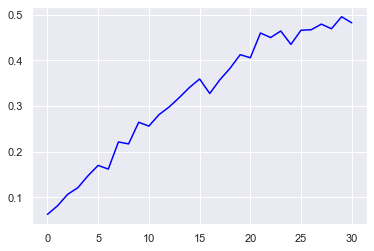

In [7]:
plt.plot(i_beta_31_06, color='blue')

In [8]:
scio.savemat('./i_beta_31_06.mat', {'i_beta_31_06': i_beta_31_06})